<a href="https://colab.research.google.com/github/beaten-by-the-market/dart_disclosure/blob/main/kospi_dart_buyback.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 코스피 상장사들의 자기주식 취득/처분결정 현황은 어떻게 될까?

**※ 데이터 수집 및 시각화 방향**

**1. OpenDART를 통해 자기주식 관련 금감원 공시 내용 수집하기**
전체 자사주 **"직접"** 취득/처분하기로 **결정한** 수량의 추이를 확인

**2. 금감원 공시에서 자사주 매매의 장내/장외를 구분하기**
장내 수량이 얼마나 많을까? 만약 생각보다 장외수량이 미미하다면 거래소 데이터만으로도 활용이 가능할 것이다!



#### 코랩 환경에서 데이터 수집, 시각화를 하기 위해 필요한 라이브러리를 설치

In [1]:
# 필요한 라이브러리 설치
import pandas as pd
import requests
from io import BytesIO, StringIO
from time import sleep
from tqdm import tqdm
from bs4 import BeautifulSoup
import json
import re
import numpy as np
from datetime import datetime

# 시각화 관련
!pip install adjustText
import matplotlib.pyplot as plt
import matplotlib.font_manager as fm
from adjustText import adjust_text

# 한글 폰트 설정 (Google Colab 환경에서)
!apt-get update -qq
!apt-get install fonts-nanum* -qq

fontpath = '/usr/share/fonts/truetype/nanum/NanumBarunGothic.ttf'
font = fm.FontProperties(fname=fontpath, size=10)

W: Skipping acquire of configured file 'main/source/Sources' as repository 'https://r2u.stat.illinois.edu/ubuntu jammy InRelease' does not seem to provide it (sources.list entry misspelt?)


#### 금감원 공시를 통해 자사주 **직접 취득** 통계 불러오기

이 데이터는 주요사항보고서(자사주취득) 공시기준 데이터이기 때문에, 실제 취득수량과는 차이가 있습니다.<br>

###### 검색기준 설정하기
검색 기준은 "유가", "2015~2024"년으로 하였습니다. 참고로 **OpenDart는 2015년부터 데이터를 제공**합니다.<br>

데이터를 불러오는 방식은 requests.post 입니다. Post방식을 위해서는 params를 설정해야 하는데, 이 안에 검색 기준이 들어가게 됩니다.

In [2]:
# 데이터 검색기준 설정하기
start_y = "2015"
end_y = "2024"
corp_type = "P" #유가는 "P", 코스닥은 "A", 유가및코스닥은 ["P", "A"] 입력
reportCode = "11332" #직접취득 11332, 직접처분 11333, 신탁취득 11334, 신탁해지 11335

# 기본 params 템플릿
params = {
    "pageIndex": "1",
    "pageSize": "10",
    "pageUnit": "10",
    "recordCountPerPage": "1000",
    "sortStdr": "crp",
    "sortOrdr": "asc",
    "sumSortStdr": "",
    "sumSortOrdr": "asc",
    "textCrpCik": "",
    "bgnDe": f"{start_y}-01-01",
    "endDe": f"{end_y}-12-31",
    "textCrpNm": "",
    "startDate": f"{start_y}-01-01",
    "endDate": f"{end_y}-12-31",
    "reportCode": f"{reportCode}",
    "corpType" : f"{corp_type}"
}

# 결과 출력
params

{'pageIndex': '1',
 'pageSize': '10',
 'pageUnit': '10',
 'recordCountPerPage': '1000',
 'sortStdr': 'crp',
 'sortOrdr': 'asc',
 'sumSortStdr': '',
 'sumSortOrdr': 'asc',
 'textCrpCik': '',
 'bgnDe': '2015-01-01',
 'endDe': '2024-12-31',
 'textCrpNm': '',
 'startDate': '2015-01-01',
 'endDate': '2024-12-31',
 'reportCode': '11332',
 'corpType': 'P'}

###### 총 몇건, 몇페이지인지 확인하기
지금같이 10년치 데이터를 확인하려면 데이터의 행이 많을 것입니다.<br>
그런데 OpenDart 웹은 기본적으로 한 페이지에 표출시켜줄 수 있는 데이터의 양이 정해져 있습니다. 따라서 10년치를 검색하면 여러 페이지에 걸쳐서 데이터가 나뉘어 표출됩니다.<br>
여러 페이지에 걸쳐 loop을 돌려야 할텐데, 몇 페이지가 있는지 어떻게 확인할까요?<br>
첫번째 페이지를 크롤링 했을 때, 그 결과물에는 전체 페이지가 얼마나 되는지 정보가 포함되어 있습니다. 그리고 이 정보를 통해 총 페이지가 2이상인 것으로 확인되는 경우, 그 페이지수만큼 추가로 크롤링을 수행해야 합니다.<br>
<br>
우선 첫번째 페이지의 크롤링을 수행해 봅니다.

In [3]:
# 첫번째 페이지를 기준으로 크롤링
url = 'https://opendart.fss.or.kr/disclosureinfo/mainMatter/list.do'
req = requests.post(url, params = params)
content = req.content.decode('utf-8')

# beautifulsoup 객체로 전환
soup = BeautifulSoup(content, 'html.parser')

# 끝에서 두번째 div 태그에 페이지 정보가 있음
output_string = soup.find_all('div')[-2].text

import re

# 정규 표현식을 사용하여 숫자 추출
match = re.match(r"\[(\d+)/(\d+)\] \[총 (\d+)건\]", output_string)

if match:
    total_page = int(match.group(2))
    total_counts = int(match.group(3))
    print(f"total_page: {total_page}")
    print(f"total_counts: {total_counts}")
else:
    print("출력물 형식이 올바르지 않습니다.")



total_page: 7
total_counts: 649


총 649건이 있고, 총 7페이지에 걸쳐있습니다.<br>
###### 데이터 수집하기
그럼 7번의 loop으로 HTML에 포함된 데이터프레임을 추출하고, 합치는 과정(pd.concat)을 진행하도록 하겠습니다.<br>
한편, 페이지 수를 확인하기 위해 이미 requests.post 한번 날려서 이미 'content'라는 변수를 받아놓았으므로, 첫번째 페이지의 데이터는 그것을 사용하고, 2페이지부터는 새로 requsts.post를 날리도록 하겠습니다.

In [4]:
# 데이터를 수집할 빈 데이터프레임(마스터 데이터프레임) 생성
df_dart_buyback = pd.DataFrame()

# 이미 받아놓은 값(content)에서 첫번째 페이지의 데이터프레임 파싱
html_string = StringIO(content)  # StringIO로 HTML 문자열 감싸기
df_loop = pd.read_html(html_string)[0]

# 마스터 데이터프레임에 합치기
df_dart_buyback = pd.concat([df_dart_buyback, df_loop])

for i in range(2, total_page + 1):
  page_index = str(i)
  # params 기준에서 페이지 인덱스만 수정하기
  params["pageIndex"] = page_index

  req = requests.post(url, params = params)
  content = req.content.decode('utf-8')
  html_string = StringIO(content)  # StringIO로 HTML 문자열 감싸기
  df_loop = pd.read_html(html_string)[0]

  # IP차단을 위해 쉬어가기
  sleep(1)

  # 마스터 데이터프레임에 합치기
  df_dart_buyback = pd.concat([df_dart_buyback, df_loop])

###### 수집된 데이터프레임 형태 확인
데이터프레임이 어떤 형태인지 한번 확인해 보겠습니다.

In [5]:
# HTML 변환 및 커스텀 태그로 감싸기
html_table = df_dart_buyback.head().to_html(index=False, classes="dataframe", escape=False)

# 테이블을 <div> 태그로 감싸기
wrapped_html = f"""
<div class="table-container">
  {html_table}
</div>
"""
print(html_table)

<table border="1" class="dataframe dataframe">
  <thead>
    <tr>
      <th>회사명</th>
      <th>접수일</th>
      <th colspan="2" halign="left">취득예정주식(주)</th>
      <th colspan="2" halign="left">취득예정금액(원)</th>
      <th colspan="2" halign="left">취득예상기간</th>
      <th colspan="2" halign="left">보유예상기간</th>
      <th>취득목적</th>
      <th>취득방법</th>
      <th>위탁투자중개업자</th>
      <th colspan="8" halign="left">취득 전 자기주식 보유현황</th>
      <th>취득결정일</th>
      <th colspan="2" halign="left">사외이사참석여부</th>
      <th>감사 (사외이사가 아닌 감사위원) 참석여부</th>
      <th colspan="2" halign="left">1일 매수 주문수량 한도</th>
      <th>비고</th>
    </tr>
    <tr>
      <th>회사명</th>
      <th>접수일</th>
      <th colspan="2" halign="left">취득예정주식(주)</th>
      <th colspan="2" halign="left">취득예정금액(원)</th>
      <th colspan="2" halign="left">취득예상기간</th>
      <th colspan="2" halign="left">보유예상기간</th>
      <th>취득목적</th>
      <th>취득방법</th>
      <th>위탁투자중개업자</th>
      <th colspan="4" halign="left">배당가능이익 범위 내 취득(주)</th>
      <th colspan

In [6]:
df_dart_buyback.head()

회사명         접수일 취득예정주식(주)         취득예정금액(원)              취득예상기간  \
       회사명         접수일 취득예정주식(주)         취득예정금액(원)              취득예상기간   
       회사명         접수일      보통주식 기타주식         보통주식 기타주식            시작일   
0  유AJ네트웍스  2021-06-09    468222    -   2565856560    -  2021년 06월 09일   
1      유CJ  2018-07-05    287770    -  40000030000    -  2018년 07월 06일   
2  유DB금융투자  2022-03-08    650000    -   3971500000    -  2022년 03월 10일   
3  유DB금융투자  2024-09-10    650000    -   3854500000    -  2024년 09월 11일   
4  유DB손해보험  2020-01-30    708000    -  30585600000    -  2020년 01월 31일   

                         보유예상기간      ... 취득 전 자기주식 보유현황                \
                         보유예상기간      ...        기타취득(주)                 
             종료일            시작일 종료일  ...          비율(%)  기타주식 비율(%).1   
0  2021년 06월 09일  2021년 06월 09일   -  ...              -     -       -   
1  2018년 10월 05일              -   -  ...            6.3  1120     0.0   
2  2022년 06월 08일              -   -  ...              -     -       -   
3  2024년 12월 10일              -   -  ...              -     -       -   
4  2020년 04월 30일              -   -  ...            0.0     -       -   

           취득결정일 사외이사참석여부       감사 (사외이사가 아닌 감사위원) 참석여부 1일 매수 주문수량 한도       \
           취득결정일 사외이사참석여부       감사 (사외이사가 아닌 감사위원) 참석여부 1일 매수 주문수량 한도        
           취득결정일    참석(명) 불참(명) 감사 (사외이사가 아닌 감사위원) 참석여부          보통주식 기타주식   
0  2021년 06월 09일        2     -                      참석             -    -   
1  2018년 07월 05일        3     -                       -         28777    -   
2  2022년 03월 08일        3     0                       -         65000    -   
3  2024년 09월 10일        3     0                       -        150745    -   
4  2020년 01월 30일        3     0                       -         70800    -   

                    비고  
                    비고  
                    비고  
0                    -  
1                    -  
2                    -  
3  2024년 09월 10일 최종보고서  
4                    -  

[5 rows x 28 columns]

확인해보니 칼럼이 3층으로 되어 있습니다. 이런 경우 분석을 하기 번거로워지는 점이 있으니, 칼럼을 1층으로 포개 주도록 하겠습니다.
3층을 1층으로 포갤때 칼럼명이 어떻게 되는지를 먼저 확인하고, 중복된 내용은 없애서는 방식으로 칼럼명을 수정하도록 하겠습니다.

In [6]:
# 3층을 1층으로 포개었을 때 어떤 칼럼명들이 생성되는지 확인
print(['_'.join(map(str, filter(None, col))) for col in df_dart_buyback.columns])

['회사명_회사명_회사명', '접수일_접수일_접수일', '취득예정주식(주)_취득예정주식(주)_보통주식', '취득예정주식(주)_취득예정주식(주)_기타주식', '취득예정금액(원)_취득예정금액(원)_보통주식', '취득예정금액(원)_취득예정금액(원)_기타주식', '취득예상기간_취득예상기간_시작일', '취득예상기간_취득예상기간_종료일', '보유예상기간_보유예상기간_시작일', '보유예상기간_보유예상기간_종료일', '취득목적_취득목적_취득목적', '취득방법_취득방법_취득방법', '위탁투자중개업자_위탁투자중개업자_위탁투자중개업자', '취득 전 자기주식 보유현황_배당가능이익 범위 내 취득(주)_보통주식', '취득 전 자기주식 보유현황_배당가능이익 범위 내 취득(주)_비율(%)', '취득 전 자기주식 보유현황_배당가능이익 범위 내 취득(주)_기타주식', '취득 전 자기주식 보유현황_배당가능이익 범위 내 취득(주)_비율(%).1', '취득 전 자기주식 보유현황_기타취득(주)_보통주식', '취득 전 자기주식 보유현황_기타취득(주)_비율(%)', '취득 전 자기주식 보유현황_기타취득(주)_기타주식', '취득 전 자기주식 보유현황_기타취득(주)_비율(%).1', '취득결정일_취득결정일_취득결정일', '사외이사참석여부_사외이사참석여부_참석(명)', '사외이사참석여부_사외이사참석여부_불참(명)', '감사 (사외이사가 아닌 감사위원) 참석여부_감사 (사외이사가 아닌 감사위원) 참석여부_감사 (사외이사가 아닌 감사위원) 참석여부', '1일 매수 주문수량 한도_1일 매수 주문수량 한도_보통주식', '1일 매수 주문수량 한도_1일 매수 주문수량 한도_기타주식', '비고_비고_비고']


###### 데이터프레임 전처리

In [7]:
# 확인된 값을 바탕으로 칼럼명을 지정
df_dart_buyback.columns = ['회사명', '접수일',
                           '취득예정주식(주)_보통주식', '취득예정주식(주)_기타주식',
                           '취득예정금액(원)_보통주식', '취득예정금액(원)_기타주식',
                           '취득예상기간_시작일','취득예상기간_종료일',
                           '보유예상기간_시작일','보유예상기간_종료일',
                           '취득목적', '취득방법', '위탁투자중개업자',
                           '취득 전 자기주식 보유현황_배당가능이익 범위 내 취득(주)_보통주식',
                           '취득 전 자기주식 보유현황_배당가능이익 범위 내 취득(주)_비율(%)',
                           '취득 전 자기주식 보유현황_배당가능이익 범위 내 취득(주)_기타주식',
                           '취득 전 자기주식 보유현황_배당가능이익 범위 내 취득(주)_비율(%).1',
                           '취득 전 자기주식 보유현황_기타취득(주)_보통주식',
                           '취득 전 자기주식 보유현황_기타취득(주)_비율(%)',
                           '취득 전 자기주식 보유현황_기타취득(주)_기타주식',
                           '취득 전 자기주식 보유현황_기타취득(주)_비율(%).1',
                           '취득결정일',
                           '사외이사참석여부_참석(명)', '사외이사참석여부_불참(명)',
                           '감사 (사외이사가 아닌 감사위원) 참석여부',
                           '1일 매수 주문수량 한도_보통주식', '1일 매수 주문수량 한도_기타주식',
                           '비고']

데이터프레임에 몇가지의 조치를 더 취합니다.
1. 분석에 필요한 칼럼만 남깁니다.<br>
물론 우선주에 대한 자기주식 취득도 있지만, 우선주가 상장되지 않은 경우가 더 많기 때문에, 보통주에 관한 것으로 한정합니다.
2. 단위를 조정합니다.<br>
칼럼이 현재는 일괄로 str타입으로 되어있습니다. 따라서 분석을 위해 날짜, 숫자 형태 등으로 변경합니다. 또한 주단위(주 → 백만주), 원단위(원 → 억원)를 변환합니다.
3. 회사명을 조정합니다.<br
OpenDart API가 아닌 웹페이지에서 크롤링해오다보니, 회사명에 다음과 같은 수식어들이 붙어있습니다. 이러한 수식어들을 제거하는 절차를 수행합니다.
  * 시장구분자(유, 코, 넥, 기)가 회사명의 앞부분에 있습니다.
  * IR홈페이지가 있는 경우, 회사명 뒷부분에 'IR'이 붙어있습니다.

In [8]:
# 필요한 칼럼만 선택하고 이름을 변경하여 새로운 데이터프레임 생성
df_dart_buyback = df_dart_buyback[['회사명', '접수일',
                           '취득예정주식(주)_보통주식',
                           '취득예정금액(원)_보통주식',
                           '취득예상기간_시작일','취득예상기간_종료일',
                           '보유예상기간_시작일','보유예상기간_종료일',
                           '취득목적', '취득방법']].copy()

df_dart_buyback.columns = ['회사명', '접수일',
                           '취득예정주식','취득예정금액','취득시작일','취득종료일',
                           '보유시작일','보유종료일','취득목적', '취득방법']

# 접수일을 datetime으로 변환 및 연도 추출
df_dart_buyback['접수일'] = pd.to_datetime(df_dart_buyback['접수일'])
df_dart_buyback['연도'] = df_dart_buyback['접수일'].dt.year

# 데이터 타입 변경
df_dart_buyback['연도'] = pd.to_numeric(df_dart_buyback['연도'], errors='coerce').astype('Int64')

df_dart_buyback['취득예정주식'] = pd.to_numeric(
    df_dart_buyback['취득예정주식'], errors='coerce').fillna(0)

df_dart_buyback['취득예정금액'] = pd.to_numeric(
    df_dart_buyback['취득예정금액'], errors='coerce').fillna(0) / 1e8  # 원 -> 억 원 변환

# 맨 앞의 '유' 또는 '코' 제거, 맨 끝의 'IR' 제거
df_dart_buyback['회사명'] = df_dart_buyback['회사명'].str.replace(r'^(유|코)', '', regex=True).str.replace(r'  IR$', '', regex=True).str.replace(r'IR$', '', regex=True)


###### 전처리한 데이터프레임 확인

In [9]:
# HTML 변환 및 커스텀 태그로 감싸기
html_table = df_dart_buyback.head().to_html(index=False, classes="dataframe", escape=False)

# 테이블을 <div> 태그로 감싸기
wrapped_html = f"""
<div class="table-container">
  {html_table}
</div>
"""
print(html_table)

<table border="1" class="dataframe dataframe">
  <thead>
    <tr style="text-align: right;">
      <th>회사명</th>
      <th>접수일</th>
      <th>취득예정주식</th>
      <th>취득예정금액</th>
      <th>취득시작일</th>
      <th>취득종료일</th>
      <th>보유시작일</th>
      <th>보유종료일</th>
      <th>취득목적</th>
      <th>취득방법</th>
      <th>연도</th>
    </tr>
  </thead>
  <tbody>
    <tr>
      <td>AJ네트웍스</td>
      <td>2021-06-09</td>
      <td>468222.0</td>
      <td>25.658566</td>
      <td>2021년 06월 09일</td>
      <td>2021년 06월 09일</td>
      <td>2021년 06월 09일</td>
      <td>-</td>
      <td>주식매수선택권 행사 재원 마련</td>
      <td>무상수증</td>
      <td>2021</td>
    </tr>
    <tr>
      <td>CJ</td>
      <td>2018-07-05</td>
      <td>287770.0</td>
      <td>400.000300</td>
      <td>2018년 07월 06일</td>
      <td>2018년 10월 05일</td>
      <td>-</td>
      <td>-</td>
      <td>주가 안정을 통한 주주가치 제고</td>
      <td>유가증권 시장을 통한 직접 취득</td>
      <td>2018</td>
    </tr>
    <tr>
      <td>DB금융투자</td>
      <td>2022-03-08</td>
      <td>65

#### 자사주 직접취득 데이터 시각화

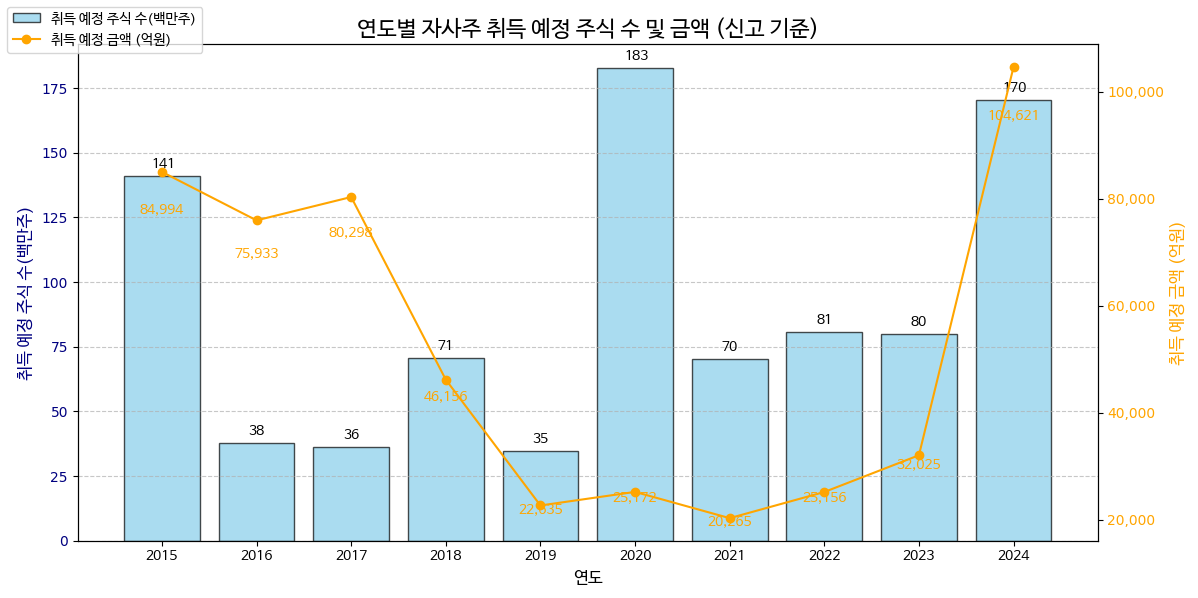

In [10]:
# 연도별 취득예정주식(주) 및 취득예정금액 집계
annual_summary = df_dart_buyback.groupby('연도').agg({
    '취득예정주식': 'sum',
    '취득예정금액': 'sum'
})

# 단위 변환
annual_summary['취득예정주식'] = annual_summary['취득예정주식'] / 1000000 # 주 -> 백만주 변환

# 그래프 크기 설정
fig, ax1 = plt.subplots(figsize=(12, 6))

# 막대 그래프: 연도별 취득 예정 주식 수
bars = ax1.bar(annual_summary.index,
               annual_summary['취득예정주식'],
               color='skyblue', edgecolor='black', alpha=0.7, label='취득 예정 주식 수(백만주)')
ax1.set_xlabel('연도', fontproperties=font, fontsize=12)
ax1.set_ylabel('취득 예정 주식 수(백만주)', fontproperties=font, fontsize=12, color='navy')
ax1.tick_params(axis='y', labelcolor='navy')

# x축 눈금 설정 (모든 연도 표시)
plt.xticks(annual_summary.index, fontproperties=font, fontsize=10)

# 데이터 라벨 추가 (막대 그래프)
texts = []
for bar in bars:
    height = bar.get_height()
    if height > 0:  # 데이터가 있는 경우에만 레이블 추가
        texts.append(ax1.text(bar.get_x() + bar.get_width() / 2., height,
                              f'{height:,.0f}', ha='center', va='bottom',
                              fontproperties=font, fontsize=10))

# 보조축 추가: 취득 예정 금액
ax2 = ax1.twinx()
line, = ax2.plot(annual_summary.index,
                 annual_summary['취득예정금액'],
                 color='orange', marker='o', label='취득 예정 금액 (억원)')
ax2.set_ylabel('취득 예정 금액 (억원)', fontproperties=font, fontsize=12, color='orange')
ax2.tick_params(axis='y', labelcolor='orange')

# y축 보조축에 천 단위 콤마 추가
ax2.yaxis.set_major_formatter(plt.FuncFormatter(lambda x, p: format(int(x), ',')))

# 선 그래프 레이블 추가
for i, value in enumerate(annual_summary['취득예정금액']):
    ax2.text(annual_summary.index[i], value*0.9, f'{value:,.0f}',
             color='orange', fontsize=10, ha='center', va='bottom', fontproperties=font)

# adjustText를 사용하여 레이블 위치 조정
adjust_text(texts, ax=ax1)

# y축 그리드 추가
ax1.grid(axis='y', linestyle='--', alpha=0.7)

# 범례 추가
fig.legend(loc='upper left', bbox_transform=ax1.transAxes, prop=font)

# 그래프 제목 설정
plt.title('연도별 자사주 취득 예정 주식 수 및 금액 (신고 기준)', fontproperties=font, fontsize=16)

# 그래프 여백 조정
plt.tight_layout()

# 그래프 표시
plt.show()


#### 금감원 공시에서 장내 vs 장외 구분자 달기
'취득방법'은 선택지로 입력하는 방식이 아니라 회사가 free text로 기재하는 방식입니다. 이렇듯 표준화되지 않은 입력값은 분석에 장애물입니다. 하지만 다행히도 칼럼의 내용을 분석해본 결과, 일정 수준의 규칙으로 장내와 장외를 구분할 수 있는 것으로 보여집니다.

###### 장내 vs 장외 구분규칙 정하기
다음의 규칙을 적용하였습니다.
1. '시장, 장내, 시간외, 거래소' 라는 표현을 포함하면 장내로 분류합니다. 띄어쓰기를 고려하여, '시간 외'도 포함합니다.
2. 조건1을 적용한 결과에서 '시장외'를 제외시킵니다.(띄어쓰기도 고려) 이는 시장외거래 라는 표현이 혹시나 존재할 경우, '시장'이라는 단어때문에 포함되는 것을 막기 위함입니다.

In [11]:
# 정규식 패턴 정의
pattern_mkt = re.compile(r'시장|장내|시간\s?외|거래소')  # '시간 외'와 '시간외'를 모두 포함
pattern_otc_exclude = re.compile(r'시장\s?외')  # '시장 외'와 '시장외'를 모두 포함

# method 열 생성
def categorize_method(method):
    if pattern_mkt.search(method) and not pattern_otc_exclude.search(method):
        return 'mkt'
    else:
        return 'otc'

# 새로운 열에 카테고리 할당
df_dart_buyback['method'] = df_dart_buyback['취득방법'].apply(categorize_method)

###### 장내 vs 장외 자사주 취득 시각화

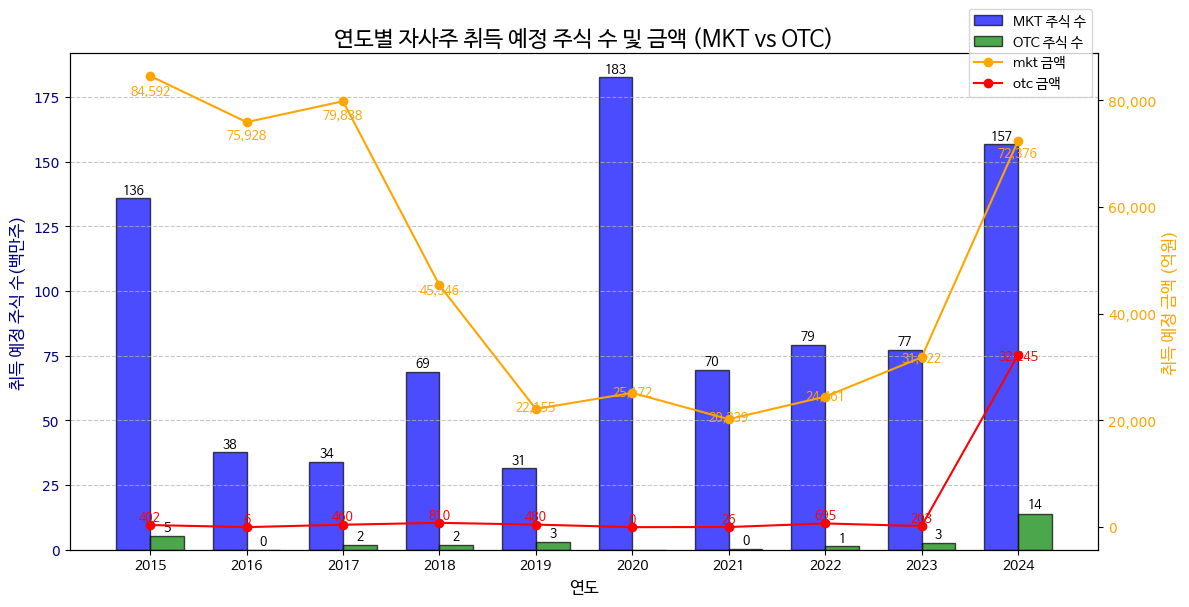

In [12]:
# 연도별 mkt, otc로 나눈 집계
annual_summary = df_dart_buyback.groupby(['연도', 'method']).agg({
    '취득예정주식': 'sum',
    '취득예정금액': 'sum'
}).reset_index()

# 단위 변환
annual_summary['취득예정주식'] = annual_summary['취득예정주식'] / 1000000 # 주 -> 백만주 변환

# 연도별로 mkt와 otc로 나눠서 데이터 생성
mkt_summary = annual_summary[annual_summary['method'] == 'mkt']
otc_summary = annual_summary[annual_summary['method'] == 'otc']

# 그래프 크기 설정
fig, ax1 = plt.subplots(figsize=(12, 6))

# 막대 그래프: mkt와 otc 별로 색상 다르게 표시
bar_width = 0.35  # 막대 폭
indices = mkt_summary['연도']  # x축 연도 값
bars_mkt = ax1.bar(indices - bar_width / 2,
                   mkt_summary['취득예정주식'],
                   color='blue', edgecolor='black', alpha=0.7, label='MKT 주식 수', width=bar_width)

bars_otc = ax1.bar(indices + bar_width / 2,
                   otc_summary['취득예정주식'],
                   color='green', edgecolor='black', alpha=0.7, label='OTC 주식 수', width=bar_width)

# 축 라벨 및 눈금 설정
ax1.set_xlabel('연도', fontproperties=font, fontsize=12)
ax1.set_ylabel('취득 예정 주식 수(백만주)', fontproperties=font, fontsize=12, color='navy')
ax1.tick_params(axis='y', labelcolor='navy')
plt.xticks(indices, fontproperties=font, fontsize=10)

# 보조축 추가: mkt와 otc의 라인 그래프
ax2 = ax1.twinx()

line_mkt, = ax2.plot(mkt_summary['연도'],
                     mkt_summary['취득예정금액'] ,
                     color='orange', marker='o', label='mkt 금액')

line_otc, = ax2.plot(otc_summary['연도'],
                     otc_summary['취득예정금액'] ,
                     color='red', marker='o', label='otc 금액')


# y축 보조축에 천 단위 콤마 추가
ax2.yaxis.set_major_formatter(plt.FuncFormatter(lambda x, p: format(int(x), ',')))

ax2.set_ylabel('취득 예정 금액 (억원)', fontproperties=font, fontsize=12, color='orange')
ax2.tick_params(axis='y', labelcolor='orange')

# 데이터 라벨 추가 (막대 및 라인 그래프)
for bar in bars_mkt:
    height = bar.get_height()
    if height > 0:
        ax1.text(bar.get_x() + bar.get_width() / 2, height * 1.00,
                 f'{height:,.0f}', ha='center', va='bottom',
                 fontproperties=font, fontsize=9)

for bar in bars_otc:
    height = bar.get_height()
    if height > 0:
        ax1.text(bar.get_x() + bar.get_width() / 2, height * 1.05,
                 f'{height:,.0f}', ha='center', va='bottom',
                 fontproperties=font, fontsize=9)

for i, value in enumerate(mkt_summary['취득예정금액'] ):
    ax2.text(mkt_summary['연도'].iloc[i], value * 0.95,
             f'{value:,.0f}', color='orange', fontsize=9,
             ha='center', va='bottom', fontproperties=font)

for i, value in enumerate(otc_summary['취득예정금액'] ):
    ax2.text(otc_summary['연도'].iloc[i], value * 0.95,
             f'{value:,.0f}', color='red', fontsize=9,
             ha='center', va='bottom', fontproperties=font)

# y축 그리드 추가
ax1.grid(axis='y', linestyle='--', alpha=0.7)

# 범례 추가
fig.legend(loc='right', bbox_to_anchor=(1, 1), bbox_transform=ax1.transAxes, prop=font)

# 그래프 제목 설정
plt.title('연도별 자사주 취득 예정 주식 수 및 금액 (MKT vs OTC)', fontproperties=font, fontsize=16)

# 그래프 여백 조정
plt.tight_layout()

# 그래프 표시
plt.show()

###### 장내 vs 장외 자사주 취득 시사점
전반적으로 장외취득은 미미한 수준인 것으로 보입니다. 그러나 2024년에 유의미하게 높은 것을 확인 가능합니다. 왜 일까요?<br>
2024년 데이터를 확인해보겠습니다. 필터를 걸고, 취득예정금액을 기준으로 내림차순으로 정렬합니다.

In [13]:
# 2024년 내역 확인
df_show = df_dart_buyback[df_dart_buyback['연도']==2024].sort_values(by='취득예정금액', ascending=False)

#필요한 칼럼만 남기기
df_show = df_show[['회사명', '접수일', '취득예정주식', '취득예정금액', '연도', 'method']]

# HTML 변환 및 커스텀 태그로 감싸기
html_table = df_show.to_html(index=False, classes="dataframe", escape=False)

# 테이블을 <div> 태그로 감싸기
wrapped_html = f"""
<div class="table-container">
  {html_table}
</div>
"""
print(html_table)

<table border="1" class="dataframe dataframe">
  <thead>
    <tr style="text-align: right;">
      <th>회사명</th>
      <th>접수일</th>
      <th>취득예정주식</th>
      <th>취득예정금액</th>
      <th>연도</th>
      <th>method</th>
    </tr>
  </thead>
  <tbody>
    <tr>
      <td>고려아연</td>
      <td>2024-10-11</td>
      <td>3623075.0</td>
      <td>32245.367500</td>
      <td>2024</td>
      <td>otc</td>
    </tr>
    <tr>
      <td>삼성전자</td>
      <td>2024-11-18</td>
      <td>50144628.0</td>
      <td>26827.375980</td>
      <td>2024</td>
      <td>mkt</td>
    </tr>
    <tr>
      <td>현대자동차</td>
      <td>2024-11-27</td>
      <td>3906545.0</td>
      <td>8731.128075</td>
      <td>2024</td>
      <td>mkt</td>
    </tr>
    <tr>
      <td>기아</td>
      <td>2024-01-25</td>
      <td>5688282.0</td>
      <td>5000.000000</td>
      <td>2024</td>
      <td>mkt</td>
    </tr>
    <tr>
      <td>NAVER</td>
      <td>2024-09-30</td>
      <td>2347500.0</td>
      <td>4011.877500</td>
      <td>2024</td>


In [14]:
# 데이터프레임 확인
df_show.head()

,회사명,접수일,취득예정주식,취득예정금액,연도,method
16,고려아연,2024-10-11,3623075.0,32245.367500,2024,otc
60,삼성전자,2024-11-18,50144628.0,26827.375980,2024,mkt
38,현대자동차,2024-11-27,3906545.0,8731.128075,2024,mkt
37,기아,2024-01-25,5688282.0,5000.000000,2024,mkt
74,NAVER,2024-09-30,2347500.0,4011.877500,2024,mkt


고려아연에서 발생한 경영권분쟁 관련 공개매수에 의한 것이었습니다. 이러한 특수한 경우를 제외하고는 "이사회 결정기준" 장외 취득의 비중은 대세에는 영향을 미치지 않는 것으로 보입니다.